[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_temporal_logic.ipynb)

# **JLNN – Temporal Logic (G, F, X) on Time-Series**

This notebook demonstrates how JLNN handles Linear Temporal Logic (LTL) operators over interval-valued time-series. We focus on three fundamental operators:
- **G (Globally/Always):** The property must hold for all steps in the time window.
- **F (Eventually/Finally):** The property must hold for at least one step in the time window.
- **X (Next):** The property must hold in the very next time step.



## **Theoretical Background: Temporal Logic in LNN**

Traditional **Linear Temporal Logic (LTL)** evaluates formulas as strictly *True* or *False* over discrete time steps. In the **Logical Neural Network (LNN)** framework, we extend this to **Interval-Valued Fuzzy Logic**, where each temporal operator propagates uncertainty through time.<br><br>

1. ***The Meaning of Truth Intervals $[L,U]$***<br>
Instead of a single scalar, JLNN tracks a lower bound $(L)$ and an upper bound $(U)$ for every time step:
    - **$L$ (Lower bound):** Minimum evidence (must be true).
    - **$U$ (Upper bound):** Maximum possibility (could be true).
    - **Uncertainty:** Defined by the width $U−L$.<br><br>

2. ***Temporal Operators as Temporal Aggregators***<br>
In JLNN, temporal operators are implemented as generalized logical gates (conjunctions and disjunctions) acting along the axis of time.<br><br>
    - **Globally ($\mathcal{G} \phi$) – "Always":**
        The formula $\phi$ must hold at every time step $t$ within the window. In fuzzy logic, this is equivalent to a **generalized conjunction (AND)**. We use the **Gödel t-norm** (minimum):<br><br>
        $$L_{\mathcal{G}\phi} = \min_{t \in \text{window}} L_{\phi(t)}, \quad U_{\mathcal{G}\phi} = \min_{t \in \text{window}} U_{\phi(t)}$$
        <br>*Insight: A single "False" or uncertain moment pulls down the truth of the entire window.* <br><br>

    - **Eventually ($\mathcal{F} \phi$) – "Finally":**
        The formula $\phi$ must hold at least once. This is a **generalized disjunction (OR)**. We use the **Gödel t-conorm** (maximum):<br><br>
        $$L_{\mathcal{F}\phi} = \max_{t \in \text{window}} L_{\phi(t)}, \quad U_{\mathcal{F}\phi} = \max_{t \in \text{window}} U_{\phi(t)}$$
        <br>*Insight: A single strong "True" signal is enough to make the entire window eventually true.* <br><br>

    - **Next ($\mathcal{X} \phi$):**
        A simple temporal shift. The truth value at time $t$ is the truth value of $\phi$ at time $t+1$.<br><br>

        $$[U,L]_{\mathcal{X}\phi(t)} = [U,L]_{\phi (t+1)}$$
        <br>

3. ***Why Use Sliding Windows?***<br>
In real-time monitoring, we don't always look at the infinite future. JLNN uses a **sliding window of size W**. This allows the model to reason about "Local Temporal Context" (e.g., *"Was the temperature high for the last 5 minutes?"*), which is critical for industrial diagnostics and signal processing.
<br>

4. ***JLNN vs. RNN/LSTM***<br>
Unlike Recurrent Neural Networks (RNNs) that store hidden states in a "black-box" fashion, JLNN temporal operators are:
    1. **Explainable:** You can trace exactly *when* and *why* a rule became false.
    2. **Deterministic:** They follow strict logical semantics.
    3. **Uncertainty-aware:** They propagate the gap between "what we know" and "what is possible".
    

## **1. Installation and automatic restart**

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB

## ***2. Imports***

In [1]:
from jlnn.symbolic.compiler import LNNFormula
import jax.numpy as jnp
from flax import nnx
import matplotlib.pyplot as plt

## ***3. Synthetic Data Generation***

We simulate a temperature sensor in a server room. We create a "fuzzy grounding" where temperature is converted into truth intervals [L, U].

#### ***1. Generate temperature time-series***

In [2]:
time_steps = 30
t = jnp.arange(time_steps)

#### Simulation: Normal temp (22°C) with a spike around step 15-20

In [3]:
temperatures = 22 + 14 * jnp.exp(-(t - 17)**2 / 15) + jnp.sin(t*0.5) * 1.5

#### ***2. Fuzzy Predicate Function: "high_temp" (Truth increases between 25°C and 35°C)***

In [4]:
def ground_high_temp(temp):
    # If temp < 25 -> False, If temp > 35 -> True
    L = jnp.clip((temp - 30) / 5, 0.0, 1.0)
    U = jnp.clip((temp - 25) / 5, 0.0, 1.0)
    return jnp.array([[L, U]])

#### ***3. Stack into (time_steps, batch=1, bounds=2)***

In [5]:
high_temp_inputs = jnp.stack([ground_high_temp(temp) for temp in temperatures])

In [6]:
print(f"Inputs shape: {high_temp_inputs.shape}") # (30, 1, 2)

Inputs shape: (30, 1, 2)


## ***4. Defining Temporal Models***

In JLNN, temporal operators are compiled as gates that operate over a sliding window.

We define three separate formulas to compare behavior

In [7]:
model_G = LNNFormula("G(high_temp)", nnx.Rngs(42)) # Always
model_F = LNNFormula("F(high_temp)", nnx.Rngs(42)) # Eventually
model_X = LNNFormula("X(high_temp)", nnx.Rngs(42)) # Next

## ***5. Inference with Sliding Window***

We slide the model over our sequence. A window_size determines the "look-back" or "look-forward" range for G and F.

In [8]:
window_size = 5

In [9]:
def run_temporal_analysis(model, inputs, window):
    results = []

    # 1. OBTAINING A REAL LOGICAL NODE
    # If model.root is of type lark.Tree, the node is in children[0]
    # If it's already Node, we'll use it directly
    if hasattr(model.root, 'children'):
        root_node = model.root.children[0]
    else:
        root_node = model.root

    for i in range(len(inputs) - window + 1):
        data_window = inputs[i : i + window]
        current_inputs = {"high_temp": data_window}

        # 2. CALL FORWARD
        # Now we call the method on AlwaysNode / EventuallyNode
        output = root_node.forward(current_inputs)

        # 3. RESULT EXTRACTION
        # output is a JAX array, we take the last time step
        res = output.reshape(-1, 2)
        L, U = float(res[-1, 0]), float(res[-1, 1])

        results.append((L, U))

    return jnp.array(results)

In [10]:
G_res = run_temporal_analysis(model_G, high_temp_inputs, window_size)
F_res = run_temporal_analysis(model_F, high_temp_inputs, window_size)
X_res = run_temporal_analysis(model_X, high_temp_inputs, window_size)

## **6. Visualization**

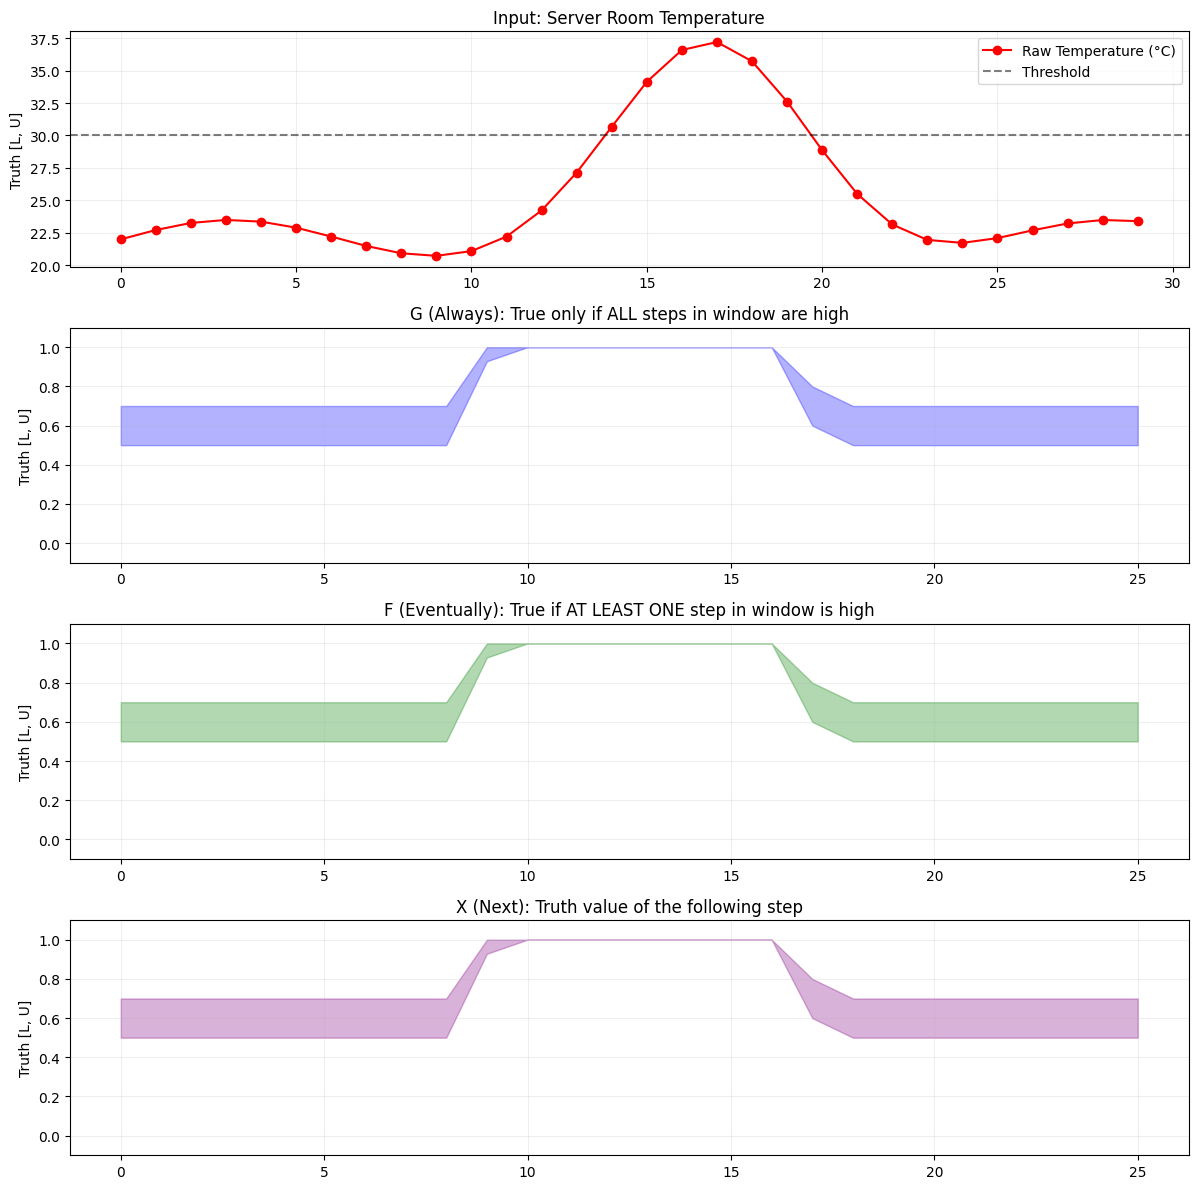

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=False)

# 1. Raw Data
axes[0].plot(t, temperatures, 'r-o', label="Raw Temperature (°C)")
axes[0].axhline(30, color='black', linestyle='--', alpha=0.5, label="Threshold")
axes[0].set_title("Input: Server Room Temperature")
axes[0].legend()

# 2. Globally (G)
t_res = jnp.arange(len(G_res))
axes[1].fill_between(t_res, G_res[:,0], G_res[:,1], color='blue', alpha=0.3, label="G(high_temp)")
axes[1].set_title("G (Always): True only if ALL steps in window are high")
axes[1].set_ylim(-0.1, 1.1)

# 3. Eventually (F)
axes[2].fill_between(t_res, F_res[:,0], F_res[:,1], color='green', alpha=0.3, label="F(high_temp)")
axes[2].set_title("F (Eventually): True if AT LEAST ONE step in window is high")
axes[2].set_ylim(-0.1, 1.1)

# 4. Next (X)
axes[3].fill_between(t_res, X_res[:,0], X_res[:,1], color='purple', alpha=0.3, label="X(high_temp)")
axes[3].set_title("X (Next): Truth value of the following step")
axes[3].set_ylim(-0.1, 1.1)

for ax in axes:
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("Truth [L, U]")

plt.tight_layout()
plt.show()

## ***6. Analysis of Results***
- **G (Always):** Notice that the blue area only rises when the temperature has been consistently high for the entire duration of the `window_size`. It is "strict".
- **F (Eventually):** The green area rises as soon as the first high temperature value enters the sliding window. It is "optimistic".
- **Intervals:** When the temperature is around the threshold (25-30°C), the interval width increases, reflecting the uncertainty of the fuzzy grounding.